## Load packages

In [1]:
using Trapz, Revise, Cuba, Interpolations, StatsPlots, IntervalSets, BAT, FileIO, LaTeXStrings, HypergeometricFunctions, SpecialFunctions, BenchmarkTools, Distributions, KernelDensity, DelimitedFiles, Memoize, NestedSamplers, JLD2, Roots, AbstractMCMC, Random, StatsBase

model = "GWTC3_BBH"
include("events.jl")
include("utils.jl")

source_to_detector_factor (generic function with 1 method)

In [2]:
h, ΩM = 1.0061, 0.54
cosmo = LCDM(h, ΩM);

In [3]:
injections0 = readdlm("/home/czc/projects/working/LIGO_posterior/O1_O2_O3_det_frame_SNR9.txt");
injections_ini = Injection(injections0[:, 1], injections0[:, 2], injections0[:, 3], injections0[:, 4], injections0[:, 5], injections0[:, 6], 266152887, 1.9945205796549974);
injections = update_cut(injections_ini, 11, 0);

Selecting injections with SNR 11 and IFAR 0 yr.


In [4]:
α, β, mmin, mmax, γ, R0 = 3.06, 1.51, 5.73, 63.09, 3.57, 28.54
m1, m2, z = 50, 30, 1.0

(50, 30, 1.0)

In [5]:
function get_PL_norm(α, minv, maxv)
    if α == -1
        log(maxv / minv)
    else
        (maxv^(α + 1) - minv^(α + 1)) / (α + 1)
    end
end

PL_prior(α, minv, maxv, m) = m^α / get_PL_norm(α, minv, maxv)

get_PL_norm(α, mmin, mmax)

5.003663760502816e6

In [6]:
struct BBH_powerlaw_R_Density <: MergerRateDensity

    mergerRateDensity::Function
    R_prior
    

    function BBH_powerlaw_R_Density(α, β, mmin, mmax, γ, R0)

        z_prior(z) = (1 + z)^γ

        function R_prior(m1, m2)
            if (mmin < m1 < mmax) & (mmin < m2 < m1)
                # m1^(-α) * m2^β 
                PL_prior(-α, mmin, mmax, m1) * PL_prior(β, mmin, m1, m2)
            else
                0
            end
        end

        mergerRateDensity(cosmo, m1, m2, z) = R0 * R_prior(m1, m2) * z_prior(z)

        new(mergerRateDensity, R_prior)
    end
end

In [7]:
struct BBH_powerlaw_R_Density2 <: MergerRateDensity

    mergerRateDensity::Function
    R_prior
    z_prior

    function BBH_powerlaw_R_Density2(α, β, mmin, mmax, γ, R0)

        z_prior(z) = (1 + z)^γ

        function R_prior(m1, m2)
            if (mmin < m1 < mmax) & (mmin < m2 < m1)
                # m1^(-α) * m2^β 
                PL_prior(-α, mmin, mmax, m1) * PL_prior(β, mmin, m1, m2)
            else
                0
            end
        end

        mergerRateDensity(cosmo, m1, m2, z) = R0 * R_prior(m1, m2) * z_prior(z)

        new(mergerRateDensity, R_prior, z_prior)
    end
end

In [63]:
@btime log(R_density.R_prior(m1_src, m2_src)) + log(source_to_detector_factor(cosmo, z) * R_density.z_prior(z))

  392.990 ns (12 allocations: 224 bytes)


-7.2155827461767075

In [166]:
m1_det, m2_det, DL = 36.72669746468108, 32.79009535587953, 0.415730350661084
m1_src, m2_src, z = detector_frame_to_source_frame(cosmo, m1_det, m2_det, DL)

(32.496887527481974, 29.01366347519151, 0.13016046332505035)

In [169]:
@btime R_density.mergerRateDensity(cosmo, m1_src, m2_src, z)

  205.361 ns (2 allocations: 48 bytes)


0.0052095048467869776

In [167]:
@btime detector_frame_to_source_frame(cosmo, m1_det, m2_det, DL)

  159.947 ns (9 allocations: 160 bytes)


(32.496887527481974, 29.01366347519151, 0.13016046332505035)

In [170]:
@btime source_to_detector_factor(cosmo, z)

  97.687 ns (4 allocations: 64 bytes)


4.026889866037794

In [171]:
260e-9 * 40*2e3

0.0208

In [124]:
Base.Broadcast.broadcastable(cosmo::Cosmology) = Ref(cosmo) 
Base.Broadcast.broadcastable(R_density::MergerRateDensity) = Ref(R_density) 

In [111]:
function detector_frame_to_source_frame(cosmo, m1_det, m2_det, DL)
    z = cosmo.z_at_DL(DL)
    m1_src = m1_det / (1 + z)
    m2_src = m2_det / (1 + z)

    m1_src, m2_src, z
end

detector_frame_to_source_frame (generic function with 1 method)

In [133]:
function t4(injections, cosmo, R_density)
    m1_det = injections.m1_det
    m2_det = injections.m2_det
    DL = injections.DL
    prior_det = injections.prior_det
    ntotal = injections.ntotal
    Tobs = injections.Tobs

    tt = detector_frame_to_source_frame.(cosmo, m1_det, m2_det, DL)
    m1_src, m2_src, z = [t[1] for t in tt], [t[2] for t in tt], [t[3] for t in tt]
    R_over_pdraws = R_over_pdraw.(cosmo, R_density, m1_src, m2_src, z, prior_det)

    sum(R_over_pdraws) / ntotal * Tobs

end

t4 (generic function with 1 method)

In [135]:
@btime t4(injections, cosmo, R_density)

  41.291 ms (2042725 allocations: 40.64 MiB)


44.20339499983339

In [163]:
@btime R_density.mergerRateDensity.(cosmo, m1_src, m2_src, z)

  6.593 ms (6 allocations: 570.55 KiB)


72989-element Vector{Float64}:
 0.010155438783924145
 0.0014061748174611698
 0.02735312214878207
 0.0
 0.0
 0.011917850248910343
 0.0
 0.0
 0.00884846441711491
 0.005536200640620109
 0.036916909521539545
 0.0
 0.01818328066179113
 ⋮
 0.0038829155821420674
 0.0
 0.008745976366136037
 0.016653607184049898
 0.006871035451786791
 0.0
 0.008123018503297467
 0.0012418203266478295
 0.02939025952206566
 0.0
 0.0
 0.009095135525227033

In [165]:
@btime detector_frame_to_source_frame.(cosmo, m1_det, m2_det, DL)

  360.950 μs (18017 allocations: 360.23 KiB)


10×200 Matrix{Tuple{Float64, Float64, Float64}}:
 (12.6045, 7.03092, 0.187817)  …  (12.1031, 7.30547, 0.191919)
 (11.1154, 7.96518, 0.187336)     (10.7954, 8.12082, 0.190264)
 (12.754, 7.12444, 0.186405)      (10.1206, 8.12504, 0.232075)
 (11.3608, 7.86814, 0.183274)     (10.8629, 7.58003, 0.226378)
 (11.5424, 7.36629, 0.207659)     (10.4152, 8.55007, 0.186881)
 (10.6508, 8.58952, 0.166562)  …  (9.23748, 8.80774, 0.241068)
 (9.57793, 9.57353, 0.164879)     (9.84119, 8.96175, 0.192269)
 (10.6813, 8.59069, 0.160907)     (12.0873, 6.96992, 0.22022)
 (11.2091, 7.94119, 0.1838)       (11.5637, 8.35445, 0.132283)
 (10.4197, 8.40821, 0.195315)     (9.68736, 8.6702, 0.211831)

In [143]:
function lnLike_single_event2(cosmo, R_density, post)
    result = 0.0
    m1_det, m2_det, DL = post[:, 1], post[:, 2], post[:, 3]
    tt = detector_frame_to_source_frame.(cosmo, m1_det, m2_det, DL)
    m1_src, m2_src, z = [t[1] for t in tt], [t[2] for t in tt], [t[3] for t in tt]
    R = R_density.mergerRateDensity.(cosmo, m1_src, m2_src, z)a
    jacobian_term = detector_to_source_jacobian.(cosmo, z)
    result = @. source_to_detector_factor(cosmo, z) * R / DL^2 / jacobian_term * 1e-6

    log(sum(result) / size(post)[1])
end

lnLike_single_event2 (generic function with 1 method)

In [147]:
@btime lnLike_single_event2(cosmo, R_density, posts[2])

  1.203 ms (54534 allocations: 1.05 MiB)


-20.539320126504226

In [148]:
@btime lnLike_single_event(cosmo, R_density, posts[2])

  1.297 ms (60003 allocations: 1.31 MiB)


-20.539320126504226

In [136]:
function t5(injections, cosmo, R_density)
    m1_det = injections.m1_det
    m2_det = injections.m2_det
    DL = injections.DL
    prior_det = injections.prior_det
    ntotal = injections.ntotal
    Tobs = injections.Tobs

    len = length(m1_det)

    R_over_pdraws = zeros(len)
    for i in 1:len
        m1_src, m2_src, z = detector_frame_to_source_frame(cosmo, m1_det[i], m2_det[i], DL[i])
        R_over_pdraws[i] = R_over_pdraw(cosmo, R_density, m1_src, m2_src, z, prior_det[i])
    end

    sum(R_over_pdraws) / ntotal * Tobs

end

t5 (generic function with 1 method)

In [137]:
t5(injections, cosmo, R_density)

44.20339499983339

In [138]:
@btime t5(injections, cosmo, R_density)

  55.250 ms (2845556 allocations: 60.68 MiB)


44.20339499983339

In [71]:
@btime R_over_pdraw(cosmo, R_density, m1_src, m2_src, z, prior_det[1])

  417.975 ns (18 allocations: 352 bytes)


658027.53087911

In [8]:
R_density = BBH_powerlaw_R_Density2(α, β, mmin, mmax, γ, R0)


0.003781530095175382

In [46]:
@btime R_density.mergerRateDensity(cosmo, m1, m2, z)


  197.238 ns (2 allocations: 48 bytes)


0.0004928340094562833

In [47]:
m1_src, m2_src, z

(32.496887527481974, 29.01366347519151, 0.13016046332505035)

In [49]:
log(R_density.mergerRateDensity(cosmo, m1_src, m2_src, z))

-5.257270466737773

In [37]:
@btime cal_Nexp(injections, cosmo, R_density)

  55.588 ms (2845556 allocations: 60.68 MiB)


44.20339499983339

In [4]:
@show GWTC3_events_heavy_mass

GWTC3_events_heavy_mass = ["150914", "151012", "151226", "170104", "170608", "170729", "170809", "170814", "170818", "170823", "190408_181802", "190412", "190413_134308", "190421_213856", "190503_185404", "190512_180714", "190513_205428", "190517_055101", "190519_153544", "190521", "190521_074359", "190527_092055", "190602_175927", "190620_030421", "190630_185205", "190701_203306", "190706_222641", "190707_093326", "190708_232457", "190720_000836", "190727_060333", "190728_064510", "190803_022701", "190828_063405", "190828_065509", "190910_112807", "190915_235702", "190924_021846", "190925_232845", "190929_012149", "190930_133541", "191105_143521", "191109_010717", "191127_050227", "191129_134029", "191204_171526", "191215_223052", "191216_213338", "191222_033537", "191230_180458", "200112_155838", "200128_022011", "200129_065458", "200202_154313", "200208_130117", "200209_085452", "200219_094415", "200224_222234", "200225_060421", "200302_015811", "200311_115853", "200316_215756", "19

69-element Vector{String}:
 "150914"
 "151012"
 "151226"
 "170104"
 "170608"
 "170729"
 "170809"
 "170814"
 "170818"
 "170823"
 "190408_181802"
 "190412"
 "190413_134308"
 ⋮
 "200224_222234"
 "200225_060421"
 "200302_015811"
 "200311_115853"
 "200316_215756"
 "190413_052954"
 "190719_215514"
 "190725_174728"
 "190731_140936"
 "190805_211137"
 "191103_012549"
 "200216_220804"

In [3]:
@show GWTC3_events_BBH

GWTC3_events_BBH = ["150914", "151012", "151226", "170104", "170608", "170729", "170809", "170814", "170818", "170823", "190408_181802", "190412", "190413_134308", "190421_213856", "190503_185404", "190512_180714", "190513_205428", "190517_055101", "190519_153544", "190521", "190521_074359", "190527_092055", "190602_175927", "190620_030421", "190630_185205", "190701_203306", "190706_222641", "190707_093326", "190708_232457", "190720_000836", "190727_060333", "190728_064510", "190803_022701", "190814", "190828_063405", "190828_065509", "190910_112807", "190915_235702", "190924_021846", "190925_232845", "190929_012149", "190930_133541", "191105_143521", "191109_010717", "191127_050227", "191129_134029", "191204_171526", "191215_223052", "191216_213338", "191222_033537", "191230_180458", "200112_155838", "200128_022011", "200129_065458", "200202_154313", "200208_130117", "200209_085452", "200219_094415", "200224_222234", "200225_060421", "200302_015811", "200311_115853", "200316_215756", 

72-element Vector{String}:
 "150914"
 "151012"
 "151226"
 "170104"
 "170608"
 "170729"
 "170809"
 "170814"
 "170818"
 "170823"
 "190408_181802"
 "190412"
 "190413_134308"
 ⋮
 "200302_015811"
 "200311_115853"
 "200316_215756"
 "190413_052954"
 "190426_152155"
 "190719_215514"
 "190725_174728"
 "190731_140936"
 "190805_211137"
 "190917_114630"
 "191103_012549"
 "200216_220804"

In [10]:
GWTC3_events_BBH = ["150914", "151226", "170104", "170608", "170809", "170814", "170818", "170823", "190408_181802", "190412", "190503_185404", "190512_180714", "190513_205428", "190517_055101", "190519_153544", "190521", "190521_074359", "190602_175927", "190630_185205", "190701_203306", "190706_222641", "190707_093326", "190708_232457", "190720_000836", "190727_060333", "190728_064510", "190828_063405", "190828_065509", "190910_112807", "190915_235702", "190924_021846", "191109_010717", "191129_134029", "191204_171526", "191216_213338", "191222_033537", "200112_155838", "200129_065458", "200202_154313", "200224_222234", "200225_060421", "200311_115853"];

In [11]:
posts0 = [get_post(event) for event in GWTC3_events_BBH];
posts = [reduce_post(post, 2000) for post in posts0];

In [12]:
post = posts[34];
lnLike_single_event(cosmo, R_density, post)


-20.066046294711587

In [13]:
lnLike_events(cosmo, R_density, posts)

-1013.4908006222649

In [14]:
function lnLike(α, β, mmin, mmax, γ, R0)
    R_density = BBH_powerlaw_R_Density(α, β, mmin, mmax, γ, R0)
    lnL0(injections, cosmo, R_density, posts)
end


lnLike (generic function with 1 method)

In [15]:
@btime lnLike(α, β, mmin, mmax, γ, R0)

  126.524 ms (5365693 allocations: 115.80 MiB)


-1028.697239780567

## Likelihood

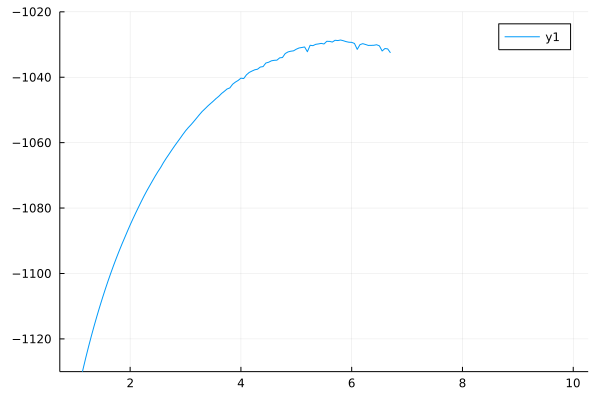

In [22]:
mmins = 1:0.05:10
lls = [lnLike(α, β, mmin, mmax, γ, R0) for mmin in mmins]
plot(mmins, lls, ylim=(-1130, -1020))

In [25]:
xs = 1.5:0.05:12
lls = [lnLike(x, β, mmin, mmax, γ, R0) for x in xs]
plot(xs, lls, ylim=(-1400, -1000), xlim=(1.5, 6))

211-element Vector{Float64}:
 -1153.5391113447358
 -1144.3408448341906
 -1135.5470865775374
 -1127.1580448199213
 -1119.172556740453
 -1111.5881572660371
 -1104.4011567746884
 -1097.6067260687769
 -1091.1989869859915
 -1085.1711070418883
 -1079.515396558218
 -1074.2234068206865
 -1069.2860279228578
     ⋮
 -1402.5376940384724
 -1405.0934717512803
 -1407.6494572643721
 -1410.2056426260554
 -1412.7620200655101
 -1415.318581988472
 -1417.8753209730191
 -1420.4322297654578
 -1422.9893012763082
 -1425.546528576383
 -1428.1039048929583
 -1430.6614236060364

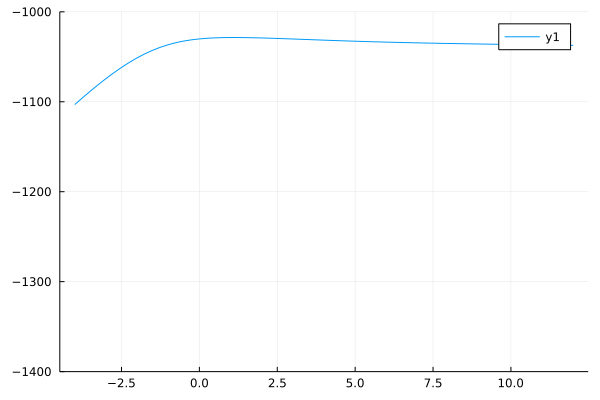

In [27]:
xs = -4:0.05:12
lls = [lnLike(α, x, mmin, mmax, γ, R0) for x in xs]


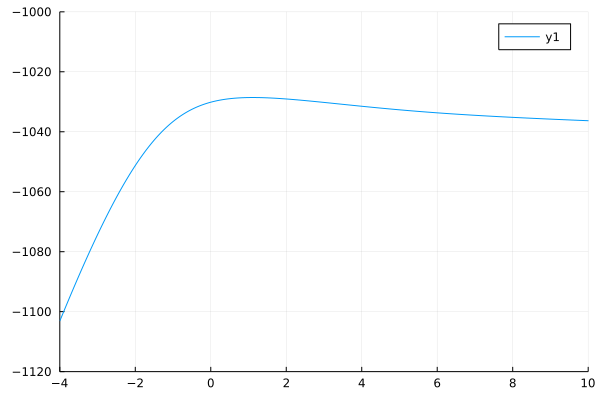

In [29]:
plot(xs, lls, ylim=(-1120, -1000), xlim=(-4, 10))

## Sampling

In [30]:
likelihood = ps -> LogDVal(lnLike(ps.α, ps.β, ps.mmin, ps.mmax, ps.γ, ps.R0))

prior = BAT.NamedTupleDist(
    α=(1.5) .. (12),
    β=(-4) .. (12),
    mmin=(2) .. (10),
    mmax=(50) .. (200),
    γ=(-4) .. (10),
    R0=(0) .. (200),
)

posterior = PosteriorDensity(likelihood, prior);

In [32]:
true_par_values = (α=α, β=β, mmin=mmin, mmax=mmax, γ=γ, R0=R0)
@time likelihood(true_par_values)

  0.150466 seconds (5.37 M allocations: 115.800 MiB, 14.25% gc time)


LogDVal{Float64}(-1028.697239780567)

In [33]:
@time begin
    println("Start sampling.")

    burnin = MCMCMultiCycleBurnin(max_ncycles=1000)
    samples, chains = bat_sample(posterior, MCMCSampling(mcalg=MetropolisHastings(), nsteps=10^4, nchains=4, burnin=burnin))
end

save("backup/samples_$model.jld2", Dict("samples" => samples, "chains" => chains))
println(" ")
println("Finish sampling and save samples.")

Start sampling.


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm PriorSubstitution()
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 3 fi

16782.660458 seconds (1.37 T allocations: 28.207 TiB, 37.97% gc time, 0.06% compilation time: 1% of which was recompilation)
 
Finish sampling and save samples.


In [34]:
samples = load("backup/samples_$model.jld2")["samples"];

In [172]:
bat_integrate(samples)

┌ Info: Using integration algorithm AHMIntegration{CholeskyPartialWhitening, GeyerAutocorLen}
│   whitening: CholeskyPartialWhitening CholeskyPartialWhitening()
│   autocorlen: GeyerAutocorLen GeyerAutocorLen()
│   volumetype: Symbol HyperRectangle
│   max_startingIDs: Int64 10000
│   max_startingIDs_fraction: Float64 2.5
│   rect_increase: Float64 0.1
│   warning_minstartingids: Int64 16
│   dotrimming: Bool true
│   uncertainty: Array{Symbol}((1,))
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	4056 / 4055	Parameters:	6
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/integration/ahmi/harmonic_mean_integration.jl:93
┌ Info: Data Whitening.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/integration/ahmi/harmonic_mean_integration.jl:108
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/integration/ahmi/harmonic_mean_integration.jl:117
┌ I

(result = NaN ± NaN, info = Parameters: 6	Total Samples: 8111
Data Set 1: 28 Volumes
Data Set 2: 27 Volumes

Integral Estimate (cov_weighted):
	 NaN  +-  NaN
, optargs = (algorithm = AHMIntegration{CholeskyPartialWhitening, GeyerAutocorLen}
  whitening: CholeskyPartialWhitening CholeskyPartialWhitening()
  autocorlen: GeyerAutocorLen GeyerAutocorLen()
  volumetype: Symbol HyperRectangle
  max_startingIDs: Int64 10000
  max_startingIDs_fraction: Float64 2.5
  rect_increase: Float64 0.1
  warning_minstartingids: Int64 16
  dotrimming: Bool true
  uncertainty: Array{Symbol}((1,))
,), kwargs = NamedTuple())

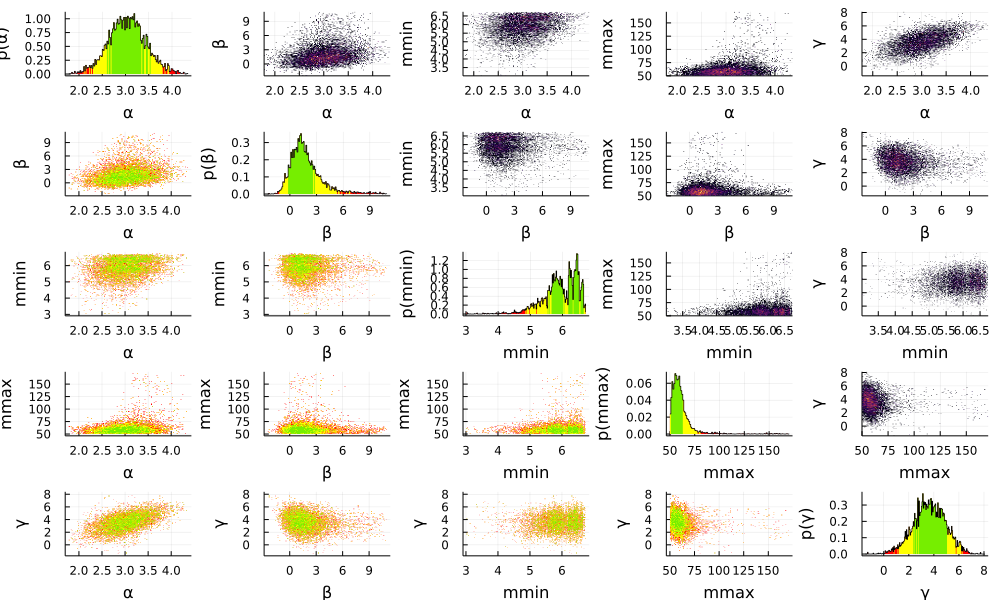

In [35]:
plot(samples)

In [42]:
# plot(
#     samples, :log_p3,
#     mean = true, std = true, globalmode = true, marginalmode = true,
#     nbins = 50, title = "Marginalized Distribution for y"
# )

In [36]:
sd = SampledDensity(posterior, samples)
display(sd)

BAT.jl - SampledDensity
──────────────────────────────

Sampling:
─────────────────────────
total number of samples:      8112
effective number of samples: (α = 377.3270670273135, β = 453.7072423380326, mmin = 695.9464935761134, mmax = 166.82561175390208, γ = 582.7651237651455, R0 = 625.6641916158436)


Parameter estimates:
─────────────────────────
number of free parameters: 6

NamedTuple{(:parameter, :mean, :std, :global_mode, :marginal_mode), Tuple{Symbol, Float64, Float64, Float64, Float64}}[(parameter = :α, mean = 3.041358888812939, std = 0.4013500993379566, global_mode = 3.1235319888440234, marginal_mode = 3.19), (parameter = :β, mean = 1.8360764153889837, std = 1.8392469355967358, global_mode = 0.9864039525355546, marginal_mode = 1.25), (parameter = :mmin, mean = 5.928519185288269, std = 0.5429455482045253, global_mode = 6.485174993056418, marginal_mode = 6.449999999999999), (parameter = :mmax, mean = 61.476765179808496, std = 12.638549742453353, global_mode = 56.23929939075151,

In [27]:
get_post(para, samples) = [a[para] for a in samples.v]

get_post (generic function with 1 method)

In [29]:
mc_posts = get_post(:mc, samples)
σc_posts = get_post(:σc, samples)
log_fpbh_posts = get_post(:log_fpbh, samples)

fpbh_posts = 10 .^ log_fpbh_posts;

In [30]:
R_posts = zeros(length(mc_posts))
Threads.@threads for i in 1:length(R_posts)
    R_posts[i] = merger_rate(mc_posts[i], σc_posts[i], fpbh_posts[i])
end

save("backup/R_posts_$model.jld2", Dict("samples" => R_posts))
R_posts = load("backup/R_posts_$model.jld2")["samples"];

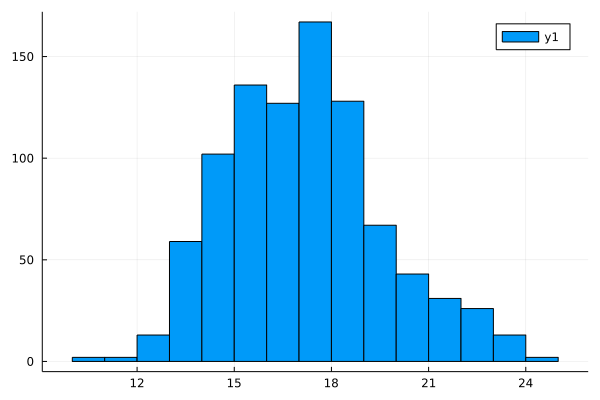

In [31]:
histogram(mc_posts)

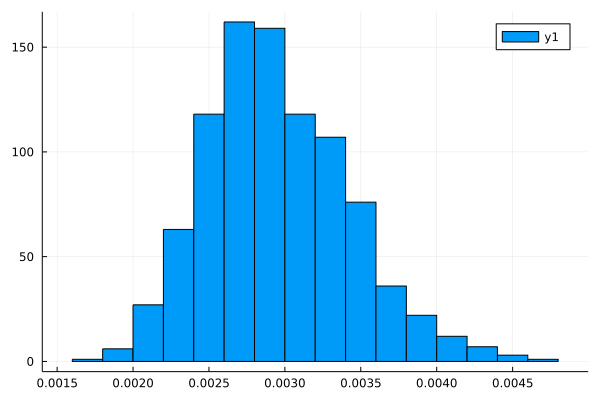

In [32]:
histogram(fpbh_posts)

In [33]:
get_quantile(posts) = quantile(posts, [0.05, 0.5, 0.95])

get_quantile (generic function with 1 method)